In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import scipy
import os
os.chdir('/content/gdrive/My Drive/MP2/')

In [0]:
def cvt2LAB(img, show):
  lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
  plt.imshow(lab)
  if(show):
    plt.show()
  
  l, a, b = cv2.split(lab)
  plt.imshow(l, cmap ='gray')
  if(show):
    plt.show()
  plt.imshow(a, cmap= 'gray')
  if(show):
    plt.show()  
  plt.imshow(b, cmap = 'gray')
  if(show):
    plt.show()

  labm = cv2.medianBlur(lab, 9)
  plt.imshow(labm)
  if(show):
    plt.show()

  return lab, labm, l, a, b

In [0]:
def extractGabor(img, ksizeRange, sigmaRange, thetaRange, gammaRange, lamdaRange, show):

  features = []
  fmasks = []
  dim = len(img.shape)
  
  for ksize in np.arange(ksizeRange[0], ksizeRange[1], ksizeRange[2]):
    for sigma in np.arange(sigmaRange[0], sigmaRange[1], sigmaRange[2]):
      for lamda in np.arange(lamdaRange[0], lamdaRange[1], lamdaRange[2]):
        for gamma in np.arange(gammaRange[0], gammaRange[1], gammaRange[2]):
          for theta in np.arange(thetaRange[0], thetaRange[1], thetaRange[2]):
            k = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)   
            fimg = cv2.filter2D(img, cv2.CV_8UC1, k)
            fimg = cv2.medianBlur(fimg, 5)
            #fimg = cv2.GaussianBlur(fimg, (51,51), 5, 5)
            
            if(show):
              plt.figure(figsize = (8,8))
              plt.imshow(fimg, cmap = 'gray')
              plt.show()
              print(ksize, sigma, gamma, lamda, theta)
            
            if(dim == 2):
              #ret,fmask = cv2.threshold(fimg,254,1,cv2.THRESH_BINARY_INV)
              #fmask = fmask.reshape((fimg.shape[0]*fimg.shape[1],))
              fimg = fimg.reshape((fimg.shape[0]*fimg.shape[1],))
              features.append(fimg)
              #features.append(fmask)
            elif(dim == 3):
              fimg = fimg.reshape((fimg.shape[0]*fimg.shape[1],3))
              features.append(fimg[:,0])
              features.append(fimg[:,1])
              features.append(fimg[:,2])
            else:
              print("Channels error")
              return 0

  
  features = np.array(features)
  features = features.T
  return features


In [0]:
def addLABfeatures(features, labm):
  features = np.hstack((features,labm[:,:,0].reshape((labm.shape[0]*labm.shape[1]),1)))
  features = np.hstack((features,labm[:,:,1].reshape((labm.shape[0]*labm.shape[1]),1)))
  features = np.hstack((features,labm[:,:,2].reshape((labm.shape[0]*labm.shape[1]),1)))
  return features

In [0]:
def kmeansClustering(features, n_clusters):
  kmeans = KMeans(n_clusters=n_clusters, init = 'k-means++')
  kmeans.fit(features)
  y = kmeans.predict(features)
  return kmeans, y

In [0]:
#Find Background Class as most populated class and setting it to zero

def bgToZero(img_seg):
  counts = np.bincount(img_seg.flatten())
  background = np.argmax(counts)
  if(background):
    print("Changing BG")
    img_seg[img_seg == background] = 255
    img_seg[img_seg == 0] = background
    img_seg[img_seg == 255] = 0
  return img_seg

In [0]:
#Finding Cell and Cytoplasm Clusters

def findCorrectLabel(img_seg,lab):

  clusters = np.unique(img_seg)
  num_clusters = len(clusters)
  clusters = clusters[1:]   #As label zero is background
  #Masks for each label
  mask1 = np.zeros(img_seg.shape)
  mask2 = np.zeros(img_seg.shape)
  
  mask1[img_seg == clusters[0]] = 255
  mask2[img_seg == clusters[1]] = 255

  #Finding histogram for a space
  hist1 = cv2.calcHist([lab],[1],np.uint8(mask1),[255],[0,256])
  peak1 = np.argsort(-hist1.flatten())[0]
  hist2 = cv2.calcHist([lab],[1],np.uint8(mask2),[255],[0,256])
  peak2 = np.argsort(-hist2.flatten())[0]
  

  if(num_clusters==3):
    if(peak1 > peak2):
      cell = clusters[0]
      cyto = clusters[1]
    else: 
      cell = clusters[1]
      cyto = clusters[0]
    m_cell=0
    b_cell=0
    return cell, cyto,b_cell,m_cell
  if(num_clusters==4):
    mask3 = np.zeros(img_seg.shape)
    mask3[img_seg == clusters[2]] = 255
    hist3 = cv2.calcHist([lab],[1],np.uint8(mask3),[255],[0,256])
    peak3 = np.argsort(-hist3.flatten())[0]
    cell=0
    p = np.array([peak1, peak2, peak3])
    ind = np.argsort(p)
    cyto = clusters[ind[0]]
    b_cell = clusters[ind[1]]
    m_cell = clusters[ind[2]]
  
  return cell,cyto,b_cell,m_cell 

In [0]:
def findTumors(lab, img_seg, cell, cyto, b_cell, m_cell, malignant, benign):  
  #Find Isolated Cells
  imgEnh = enhance(lab)
  if(malignant):
    isoMask = getIsolatedCells(imgEnh, 70)
  else:
    isoMask = getIsolatedCells(imgEnh)
  

  #Finding contours and respective areas
  contours, heirarchy = cv2.findContours(np.uint8(img_seg), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  n = len(contours)
  areas = []
  for cnt in contours:
    area = cv2.contourArea(cnt)
    areas.append(area)

  #Sorting areas in descending order 
  areas = np.array(areas)
  ind = np.argsort(-1*areas)

  #Getting indices of tumours
  numTumors = malignant + benign
  tumorInd = ind[0:numTumors]
  z = np.zeros(img_seg.shape)
  
  if(not malignant or not benign):
    #Creating a mask with tumors of largest area
    for i in tumorInd:
      cv2.drawContours( z, contours[i], -1, (255,255,255), 3)

    masked_image = scipy.ndimage.morphology.binary_fill_holes(z)
    z[masked_image] = img_seg[masked_image]
    z = np.int64(z)
    plt.imshow(z)
    plt.show()
    counts = np.bincount(z.flatten())
    
    if(len(counts)-1 < cell or len(counts)-1 <cyto):
      counts = np.append(counts, [0])

   
    if(counts[cell] < counts[cyto]):
      img_seg[z == cyto] = 0
      img_seg = findTumors(lab, img_seg, cell, cyto, b_cell, m_cell, malignant, benign)
    else:      
      img_seg[img_seg == cyto] = 0
      img_seg[isoMask] = cell
      img_seg[masked_image] = cyto
  else:
    tumor = np.zeros(img_seg.shape)
    for i in np.arange(0,numTumors,1):      
      z = np.zeros(img_seg.shape)
      cv2.drawContours(z,contours[ind[i]], -1,(255,255,255), 3 )
      cv2.drawContours(tumor,contours[ind[i]], -1,(255,255,255), 3 )
      masked_image = scipy.ndimage.morphology.binary_fill_holes(z)
      z[masked_image] = img_seg[masked_image]
      counts = np.bincount(img_seg[masked_image].flatten())
      if(len(counts)-1 < m_cell or len(counts)-1 <cyto or len(counts)-1 <b_cell):
        counts = np.append(counts, [0])

      print(counts[m_cell], counts[b_cell], counts[cyto])
      if(counts[m_cell] >= counts[cyto] and counts[m_cell]> counts[b_cell]):
        img_seg[masked_image] = m_cell
      elif (counts[b_cell]> counts[m_cell] ):
        img_seg[masked_image] = b_cell       
      else:
        img_seg[z == cyto] = 0
        img_seg = findTumors(img_seg, cell, cyto, b_cell, m_cell, malignant, benign)
      
    img_seg_with_iso = np.copy(img_seg)
    tumorMask = scipy.ndimage.morphology.binary_fill_holes(tumor)
    img_seg[img_seg == cyto] = 0
    img_seg[img_seg == b_cell] = cyto
    img_seg[isoMask] = cyto
    img_seg[tumorMask] = img_seg_with_iso[tumorMask] 

  return img_seg

In [0]:
def enhance(lab):
  l,a,b = cv2.split(lab)
  clahe = cv2.createCLAHE(clipLimit=7.0, tileGridSize=(8,8))
  cla = clahe.apply(a)
  #plt.imshow(cla)
  #plt.show()

  #-----Merge the CLAHE enhanced L-channel with the a and b channel-----------
  limg = cv2.merge((l,cla,b))
  #plt.imshow(limg)
  #plt.show()

  return cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)


In [0]:
def getIsolatedCells(imgEnh, *args):
  
  if(len(args)):
    thresh = args[0]
  else:
    thresh = 50   #After Histogram Analysis
  
  #imgEnh[:,:,1] = cv2.medianBlur(imgEnh[:,:,1], 9)
  isoMask = imgEnh[:,:,1] < thresh

  return isoMask 
  

In [0]:
def diceScore(num_clusters, img_seg, img_gt,no_malig,no_benign):
  """Dice Score"""
  isolatedMask = img_seg
  img_gt_gray = cv2.cvtColor(img_gt,cv2.COLOR_BGR2GRAY)
  if(len(isolatedMask[(isolatedMask<1) & (isolatedMask>0)])!=0):
    isolatedMask[(isolatedMask<1) & (isolatedMask>0)]=2

  gray_values=[]
  img_shape = img_gt_gray.shape
  img_gt_gray.reshape(img_shape[0]*img_shape[1])
  isolatedMask.reshape(img_shape[0]*img_shape[1])
  
  for i in range(num_clusters-1):
    gray_values.append(int(np.mean(img_gt_gray[(img_gt_gray>=255*i/(num_clusters)) & (img_gt_gray<255*(i+1)/(num_clusters))])))
  gray_values.append(255)
  print(gray_values)
  for i in range(num_clusters):
    img_gt_gray[img_gt_gray==gray_values[i]]=num_clusters-1-i

  gt_pixel_ratios=[]
  seg_pixel_ratios=[]
  for i in range(num_clusters):
    seg_pixel_ratios.append(np.sum(isolatedMask[isolatedMask==i]==i))
    gt_pixel_ratios.append(np.sum(img_gt_gray[img_gt_gray==i]==i))

  

  seg_order = np.argsort(seg_pixel_ratios)
  

  gt_order = np.argsort(gt_pixel_ratios)
  

  for i in range(num_clusters):
    isolatedMask[isolatedMask==seg_order[i]]= num_clusters+gt_order[i]
  for i in range(num_clusters):
    isolatedMask[isolatedMask==(num_clusters+gt_order[i])]= gt_order[i]
    
  isolatedMask.reshape((img_shape[0],img_shape[1]))


  
  dice = []
  confusion_matrix=[]
  for k in range(num_clusters):
    dice.append(np.sum(isolatedMask[img_gt_gray==k]==k)*2.0 / (np.sum(isolatedMask[isolatedMask==k]==k) + np.sum(img_gt_gray[img_gt_gray==k]==k)))
    row=[]
    for i in range(num_clusters):
      row.append(np.sum(img_gt_gray[isolatedMask==i]==k))
    confusion_matrix.append(row)
    
  print(dice)
  print(confusion_matrix)

In [0]:
def main(new, img_fname, *args):
  
  #Reading images
  img = cv2.imread(img_fname)
  if(not new): #If not a new image
    img_gt_fname = args[0]
    img_gt = cv2.imread(img_gt_fname)
    img_gt = np.array(img_gt)
  
  plt.imshow(img)
  plt.show()
  
  print("Malignant:")
  mal = input()
  print("Benign: ")
  ben = input()

  mal = int(mal)
  ben = int(ben)
  if(not mal or not ben):
    num_clusters = 3
  else:
    num_clusters = 4

  #Convert to Lab Space
  # Outputs : lab space, median filtered lab images, l, a, b channels separately
  # Inputs : rgb image, show = 1, to show the lab images. Show = 0 to not display
  lab,labm, l, a, b = cvt2LAB(img,0)

  #Extract Gabor Features
  # FN: extractGabor(img, ksizeRange, sigmaRange, thetaRange, gammaRange, lamdaRange, show)
  features = extractGabor(lab, [9,10,2], [1,2,1], [0,1,1], [0.5,1.25,0.25], [3.25,4.1,0.25], 0)

  #Feature Selection
  features = np.hstack([features[:,0:12], features[:,18:36]])

  #Adding LAB Colour channels to feature space
  #features = addLABfeatures(features, labm)

  #Kmeans - inputs : feature vectors, no. of clusters
  #Kmeans - outputs : kmeans object, label vector
  [kmeans, y] = kmeansClustering(features, num_clusters)
  img_seg = y.reshape((img.shape[0], img.shape[1]))
  img_seg = cv2.medianBlur(np.uint8(img_seg), 9)

  #Display Image
  plt.figure()
  plt.imshow(img)
  plt.title('Original image', fontsize = 20)
  plt.show()
  plt.figure()
  plt.imshow(img_seg , cmap = 'gray')
  plt.title('Segmented image after kmeans', fontsize = 20)
  plt.show()

  #Re-labelling the image
  img_seg = bgToZero(img_seg)
  cell, cyto,b_cell, m_cell = findCorrectLabel(img_seg, lab) #Finds the correct labels for cell and cytoplasm clusters 

  #Finding the tumors
  img_seg_copy = np.copy(img_seg)
  img_seg_withTumor = findTumors(lab, img_seg_copy, cell, cyto, b_cell, m_cell, mal, ben)

  #Dice Score 
  if(not new):
    fig2, (a3,a4) = plt.subplots(1,2, figsize=(15,15))
    a3.imshow(img_seg_withTumor, cmap = 'gray')
    a3.set_title('Final Segmented Image Output', fontsize = 20)
    a4.imshow(img_gt)
    a4.set_title('Ground Truth', fontsize = 20)
    fig2.show()
    dice = diceScore(num_clusters, img_seg_withTumor, img_gt, mal, ben)
  else:
    plt.figure(figsize = (10,10))
    plt.imshow(img_seg_withTumor, cmap = 'gray')
    plt.title('Final Segmented Image Output', fontsize = 15)
    plt.show()
  
  return img_seg_withTumor

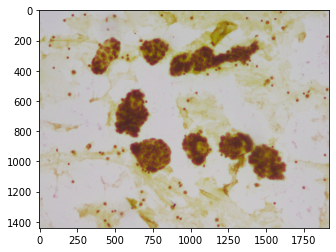

Malignant:
7
Benign: 
0


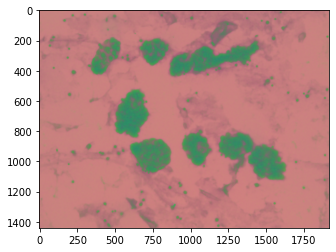

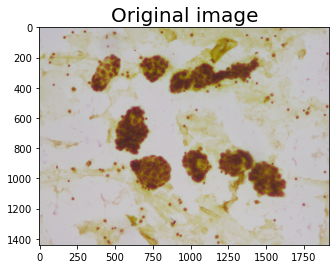

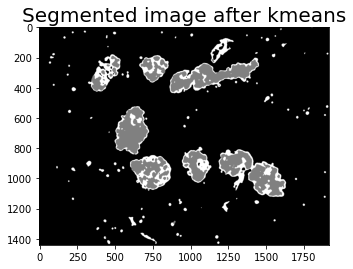

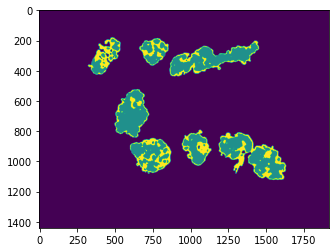

[76, 164, 255]
[0.9946725711716999, 0.7718032786885246, 0.9722605520106933]
[[2409651, 1509, 11936], [6587, 14124, 256], [5780, 0, 314957]]


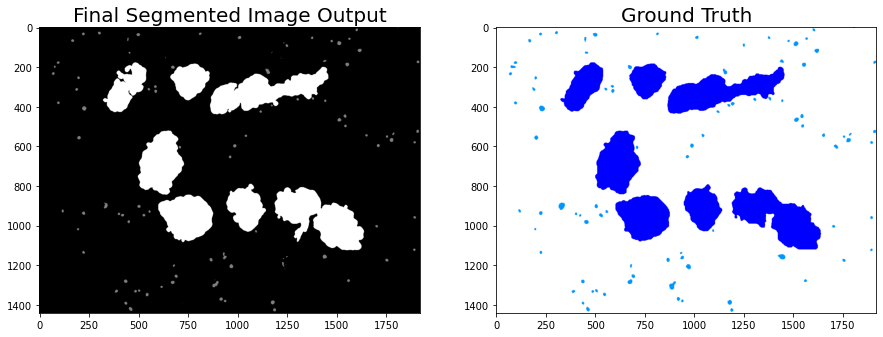

In [79]:
img_seg = main(0, 'malignant_4x/_11019.tif', 'malignant_4x/_11019_gt.png')

In [0]:
print(cv2.cvtColor(img_gt)